<a href="https://colab.research.google.com/github/kylelee417/Data-Science_Portfolio/blob/master/chest_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 !pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
from google.colab import drive #Google supported code snippet, mounting the Google drive to import the images
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Import Libraries**

In [3]:
import cv2
import os
import itertools

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix

from glob import glob #retriving an array of files in directories
from keras.models import Sequential #for neural network models
from keras.layers import Input, Dense, Flatten,Conv2D, ZeroPadding2D, MaxPooling2D, Dropout # Import hidden layer
from keras.preprocessing.image import ImageDataGenerator #Data augmentation and preprocessing
from keras.optimizers import Adam #For Optimizing the Neural Network
from keras.applications.vgg16 import VGG16 # VGG16 saved model from keras
from keras import layers
from keras.layers import Input
from keras.models import Model




Using TensorFlow backend.


In [4]:
#Checking dataset
paths = os.listdir(path="/content/gdrive/My Drive/chest_xray/")
print(paths)

['val', 'test', '.DS_Store', 'train']


In [0]:
#Path to all image data
train_path = "/content/gdrive/My Drive/chest_xray/train"
dev_path = "/content/gdrive/My Drive/chest_xray/val"
test_path = "/content/gdrive/My Drive/chest_xray/test"

In [0]:
#Getting all normal and pneumonia images from the folder
img_pne = glob(train_path+"/PNEUMONIA/*.jpeg")
img_norm = glob(train_path+"/NORMAL/*.jpeg")

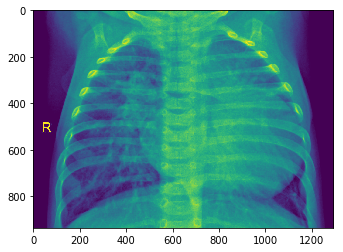

In [7]:
#First pnumonia image
img_pne_0 = np.asarray(plt.imread(img_pne[0]))
plt.imshow(img_pne_0)



In [8]:
# image shape
img_pne_0.shape

(936, 1292)

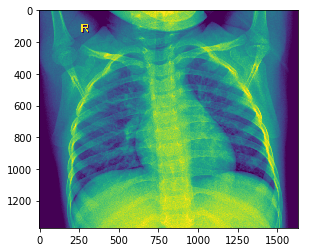

In [9]:
#First normal image
img_norm_0 = np.asarray(plt.imread(img_norm[0]))
plt.imshow(img_norm_0)

In [10]:
#image shape
img_norm_0.shape

(1372, 1634)

## Data pre-processing and Analysis

In [0]:
# Loading images
classes = ["NORMAL", "PNEUMONIA"]
train_data = glob(train_path+"/NORMAL/*.jpeg")
train_data += glob(train_path+"/PNEUMONIA/*.jpeg")
data_gen = ImageDataGenerator(rescale=1./255) # No augmentation here but normalized

In [12]:
#flow_from_directory feature, re-size image 
train_batches = data_gen.flow_from_directory(train_path, target_size = (224, 224), classes = classes, class_mode = "binary",batch_size=16)
val_batches = data_gen.flow_from_directory(dev_path, target_size = (224, 224), classes = classes, class_mode = "binary",batch_size=16)
test_batches = data_gen.flow_from_directory(test_path, target_size = (224, 224), classes = classes, class_mode = "binary",batch_size=16)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
#chech re-sized image shape
X_input = train_batches.image_shape
X_input

(224, 224, 3)

## First model using VGG16 template

In [14]:
#Transfer learning from a convolutional ANN model
#VGG16 model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=train_batches.image_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) #Since the output is binary, sigmoid is used to speed of the process

W0727 05:58:06.737145 139901480802176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 05:58:06.751863 139901480802176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 05:58:06.757567 139901480802176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 05:58:06.784471 139901480802176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0727 05:58:06.962651 139901480802176 deprecation_wrapp

In [15]:
learning_rate = 0.0005
optimizer = Adam(lr = 0.0001)
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optimizer)

W0727 05:58:07.049044 139901480802176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0727 05:58:07.056183 139901480802176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0727 05:58:07.061744 139901480802176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## First model fit

In [16]:

his = model.fit_generator(epochs=100,
                           shuffle=True,
                           validation_data=val_batches,
                           generator=train_batches,
                           steps_per_epoch=np.ceil(len(train_batches) / 16),
                           validation_steps=21,
                           verbose=1)

Epoch 1/100
21/21 [==============================] - 21s 1s/step - loss: 0.6721 - acc: 0.7321 - val_loss: 0.7477 - val_acc: 0.5000
Epoch 2/100
21/21 [==============================] - 9s 441ms/step - loss: 0.5540 - acc: 0.7708 - val_loss: 0.7607 - val_acc: 0.5000
Epoch 3/100
21/21 [==============================] - 9s 443ms/step - loss: 0.5735 - acc: 0.7470 - val_loss: 0.8399 - val_acc: 0.5000
Epoch 4/100
21/21 [==============================] - 9s 451ms/step - loss: 0.5820 - acc: 0.7321 - val_loss: 0.8700 - val_acc: 0.5000
Epoch 5/100
21/21 [==============================] - 10s 455ms/step - loss: 0.5718 - acc: 0.7202 - val_loss: 0.9617 - val_acc: 0.5000
Epoch 6/100
21/21 [==============================] - 9s 452ms/step - loss: 0.6719 - acc: 0.7054 - val_loss: 0.6920 - val_acc: 0.5000
Epoch 7/100
21/21 [==============================] - 9s 445ms/step - loss: 0.5234 - acc: 0.7589 - val_loss: 1.8519 - val_acc: 0.5000
Epoch 8/100
21/21 [==============================] - 9s 445ms/step - l

In [0]:
#Source: helper_module.py by Sean Choi:
#https://github.com/sungsujaing/Happy_Dog_Detection/blob/master/helper_module.py

#A fuction to graph loss and accuracy from the fitting
def training_plot(hist,model_name):
    loss = [hist.history['loss'],hist.history['val_loss']]
    acc = [hist.history['acc'],hist.history['val_acc']]
    
    fig, axes = plt.subplots(1,2,figsize = (15,3))
    fig.suptitle(model_name)
    for ax,val,name in zip(axes,(loss,acc),['loss','accuracy']):
        ax.plot(val[0], color='b', label="Training")
        ax.plot(val[1], color='r', label="Validation")
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)

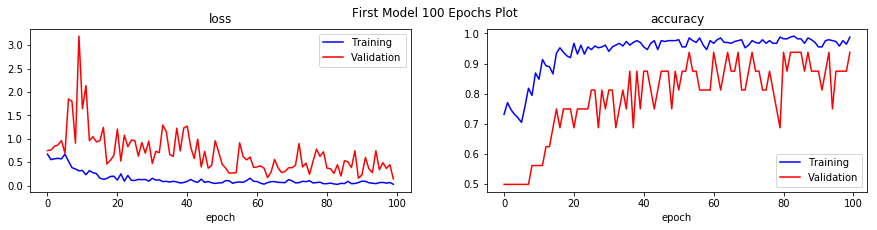

In [18]:
training_plot(his,'First Model 100 Epochs Plot')

## Prediction using the First model

In [0]:
predict1 = model.predict_generator(test_batches,test_batches.samples // test_batches.batch_size)

In [20]:
len(predict1)

624

In [0]:
empt = []
for i in predict1:
  if i < 0.5:
    i = 0
  else:
    i = 1
  empt.append(i)
    

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


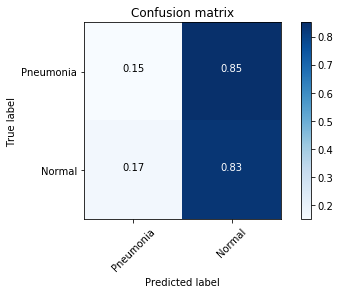

In [23]:
cm = confusion_matrix(test_batches.classes, empt)
plot_confusion_matrix(cm,normalize=True
                      , classes=['Pneumonia', 'Normal'])

## **Transfer learning from VGG16 - Fine tuning**




In [0]:
X_input = Input(train_batches.image_shape)

model_vgg16 = VGG16(include_top=False, weights='imagenet',input_tensor=X_input)
last_layer = model_vgg16.get_layer('block5_pool').output
X2 = Flatten(name='flatten')(last_layer)
X2 = Dense(128,activation='relu',name='fc1')(X2)
X2 = Dense(1,activation='sigmoid',name='output')(X2)
model_vgg16= Model(inputs = X_input, outputs = X2)

###Freeze the pre-trined CNN weights

In [25]:
for layer in model_vgg16.layers[:-3]:
    layer.trainable = False
model_vgg16.compile(optimizer = optimizer,loss='binary_crossentropy',metrics=['accuracy'])

his_2 = model_vgg16.fit_generator(epochs=100,shuffle=True, validation_data=val_batches,
                           generator=train_batches,
                           steps_per_epoch=np.ceil(len(train_batches) / 16),
                           validation_steps=21,
                           verbose=1)

Epoch 1/100
21/21 [==============================] - 9s 405ms/step - loss: 0.3572 - acc: 0.8542 - val_loss: 0.4380 - val_acc: 0.8125
Epoch 2/100
21/21 [==============================] - 6s 263ms/step - loss: 0.1079 - acc: 0.9494 - val_loss: 0.4728 - val_acc: 0.8750
Epoch 3/100
21/21 [==============================] - 6s 279ms/step - loss: 0.1540 - acc: 0.9405 - val_loss: 0.4701 - val_acc: 0.7500
Epoch 4/100
21/21 [==============================] - 5s 259ms/step - loss: 0.0988 - acc: 0.9613 - val_loss: 0.1183 - val_acc: 0.9375
Epoch 5/100
21/21 [==============================] - 6s 263ms/step - loss: 0.1958 - acc: 0.9196 - val_loss: 0.1038 - val_acc: 0.9375
Epoch 6/100
21/21 [==============================] - 6s 285ms/step - loss: 0.1634 - acc: 0.9524 - val_loss: 0.2911 - val_acc: 0.8750
Epoch 7/100
21/21 [==============================] - 5s 253ms/step - loss: 0.0729 - acc: 0.9792 - val_loss: 0.6087 - val_acc: 0.6875
Epoch 8/100
21/21 [==============================] - 5s 254ms/step - 

In [26]:
#First model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
__________

In [27]:
#Transfer-learning model summary
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

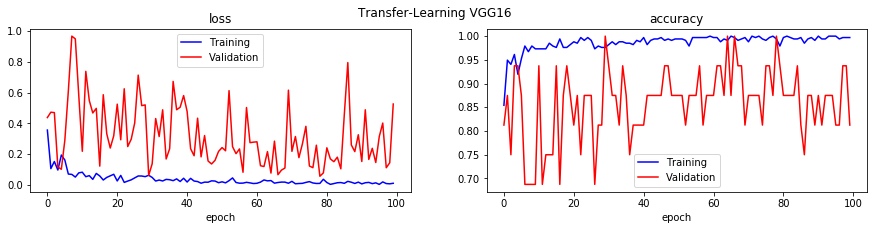

In [28]:
training_plot(his_2, 'Transfer-Learning VGG16')

## Prediction using the VGG16 pre-trained weights

In [0]:
predict2 = model_vgg16.predict_generator(test_batches,test_batches.samples // test_batches.batch_size)

In [0]:
empt2 = []
for i in predict2:
  if i < 0.5:
    i = 0
  else:
    i = 1
  empt2.append(i)

Normalized confusion matrix


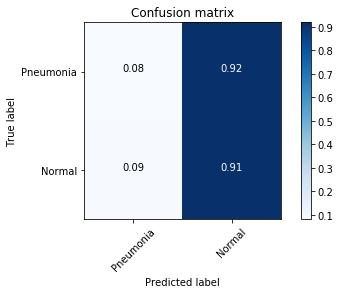

In [31]:
cm2 = confusion_matrix(test_batches.classes, empt2)
plot_confusion_matrix(cm2, normalize=True, classes=['Pneumonia', 'Normal'])

## Performace

In [0]:
def print_valid_test_score(model,val_generator,test_generator, steps):
    val_generator1 = model.evaluate_generator(val_generator,steps=steps)
    test_generator1 = model.evaluate_generator(test_generator, steps=steps)
    print("Valid: accuracy = %f  ;  loss = %f" % (val_generator1[1]*100, val_generator1[0]*100))
    print("Test: accuracy = %f  ;  loss = %f" % (test_generator1[1]*100, test_generator1[0]*100))

In [33]:
print_valid_test_score(model, val_batches, test_batches, 21)

Valid: accuracy = 93.750000  ;  loss = 14.242923
Test: accuracy = 77.380952  ;  loss = 132.762506


In [34]:
print_valid_test_score(model_vgg16, val_batches, test_batches, 21)

Valid: accuracy = 81.250000  ;  loss = 52.558148
Test: accuracy = 72.619048  ;  loss = 136.809949


In [0]:
#Getting all normal and pneumonia test images from the folder
img_pne_test = glob(test_path+"/PNEUMONIA/*.jpeg")
img_norm_test = glob(test_path+"/NORMAL/*.jpeg")

img_test_all = img_pne_test[:]+img_norm_test[:]


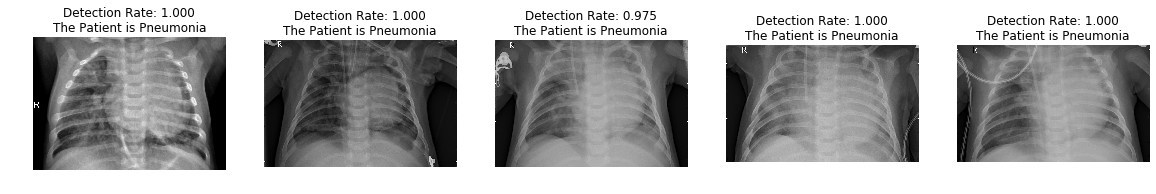

In [36]:
#First model detection
fig, axes = plt.subplots(1, 5, figsize = (4*5, 3*1))
for ax,img_num in zip(axes,img_test_all):
    img = cv2.imread(img_num)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    img = cv2.resize(img,(244,244)).astype('float32')
    img /= 255
    img = np.expand_dims(img,axis=0)
    ax.axis('off')
    predict_rate1 = model.predict_generator(test_batches,test_batches.samples // test_batches.batch_size)[0][0]
    
    if predict_rate1.any() >= 0.5:
        predict_class = 'Pneumonia'
    else: predict_class = 'Normal'
    ax.set_title('Detection Rate: {:.3f}\nThe Patient is {}'.format(predict_rate1, predict_class))

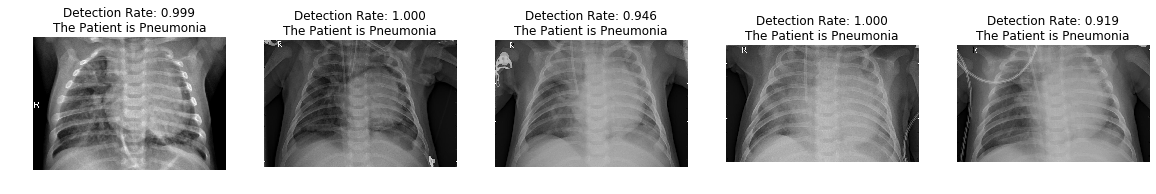

In [37]:
#VGG16 Transfer-Learning detection
fig, axes = plt.subplots(1, 5, figsize = (4*5, 3*1))
for ax,img_num in zip(axes,img_test_all):
    img = cv2.imread(img_num)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    img = cv2.resize(img,(244,244)).astype('float32')
    img /= 255
    img = np.expand_dims(img,axis=0)
    ax.axis('off')
    predict_rate2 = model_vgg16.predict_generator(test_batches,test_batches.samples // test_batches.batch_size)[0][0]
    
    if predict_rate2.any() >= 0.5:
        predict_class = 'Pneumonia'
    else: predict_class = 'Normal'
    ax.set_title('Detection Rate: {:.3f}\nThe Patient is {}'.format(predict_rate2, predict_class))